# 3D pose extraction from 2D orthographic projection with DRaM

In this notebook we will demonstrate how to use the determinant ratio matrix (DRaM) to determine the pose of a 3D point cloud from its 2D orthographic projection.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from AdjQuat import utils
from AdjQuat import simulators
from AdjQuat import solutions

## 1. Data generation

First we will set up our data generation process.

In [4]:
# We define a manual seed for reproducilibity.
torch.manual_seed(0)

In [5]:
# First we generate random points in 3D space
npts = 50
xyz = torch.randn(npts, 3, dtype=torch.double)

In [6]:
xyz[0] # just to check our first point is the same for different runs

tensor([-2.3104, -0.3733, -1.0608], dtype=torch.float64)

We rotate this using the standard rotation matrix in terms of our quaternion ($\vec{q}=[q_0,q_1,q_2,q_3]$):

$$ {R}(\vec{q}) = \left[ \begin{array}{cc}  q_0^2 + q_1^2 - q_2^2 - q_3^2 & 2q_1q_2 - 2q_0q_3 & 2q_1q_3 + 2q_0q_2 \\ 2q_1q_2 + 2q_0q_3 & q_0^2 - q_1^2 + q_2^2 - q_3^2 & 2q_2q_3 - 2q_0q_1 \\ 2q_1q_3 - 2q_0q_2 & 2q_2q_3 + 2q_0q_1 &  q_0^2 - q_1^2 - q_2^2 + q_3^2 \end{array} \right]
$$

We will rotate this set of initial points by a small rotation to confirm our functions work as expected.

In [7]:
quaternion_small = np.array([np.cos(0.1),(1/np.sqrt(3))*np.sin(0.1),(1/np.sqrt(3))*np.sin(0.1),(1/np.sqrt(3))*np.sin(0.1)])

In [8]:
#convert to a rotation matrix and dot with our point cloud
rotation_small = utils.quat_to_rot(quaternion_small)
small_rot_xyz = rotation_small.dot(np.asarray(xyz).T).T

In [9]:
#convert to a projection matrix and dot with our point cloud
proj_small = utils.quat_to_proj(quaternion_small)
small_proj_xyz = proj_small.dot(np.asarray(xyz).T).T

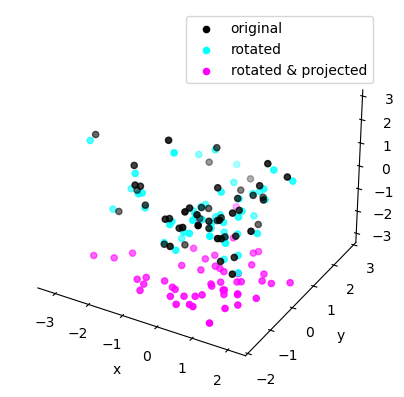

In [10]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2],color='black',label='original');
ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='rotated');
ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='rotated & projected');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

The function we will actually use to generate data also includes added error:

In [126]:
sigma = 0.1
UV, xyz_error = utils.make_U3(xyz,quaternion_small,sigma)

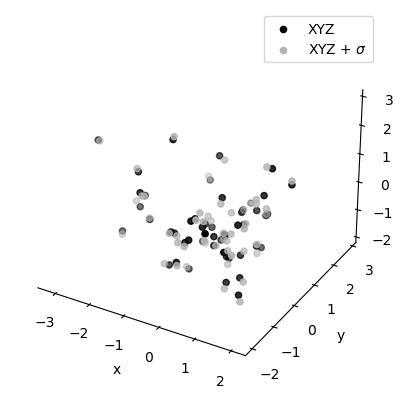

In [12]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2],color='black',label='XYZ');
ax.scatter3D(xyz_error[:,0],xyz_error[:,1],xyz_error[:,2],color='0.7',label='XYZ + $\sigma$');
#ax.scatter3D(UV[:,0],U[:,1],np.zeros(len(U.T[0]))-3,color='magenta',label='UV = (X + $\sigma$) $\cdot$ P');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

## 2. Now let's evaluate our DRaM solution for this dataset.

Now we want to test equation (XX), which only gives a rotation matrix in the no noise case:

%% Derived  near bottom of. Pose-3D-working-1.nb WWW  - now reduce to determinants:
%%. detRulePose3D and revDetRulePose3D. and VVV do Rot3 cross-product det6, 9, 10
%%. TABLE of the remaining determinants in Pose-3D2D-Summary.nb. "DET TABLE"

$$
\tilde{R}(x,y,z;u,v)  = \left[ \begin{array}{ccc}
 \displaystyle\frac{d_{7}}{d_{1}} &     
              -\displaystyle\frac{d_{4}}{d_{1}} & 
                        \displaystyle\frac{d_{2}}{d_{1}}\\[0.15in]
 \displaystyle\frac{d_{8}}{d_{1}} &
    -\displaystyle\frac{d_{5}}{d_{1}} &
             \displaystyle\frac{d_{3}}{d_{1}}\\[0.15in]
         \displaystyle\frac{d_{6}}{d_{1}} &
       \displaystyle\frac{d_{9}}{d_{1}} &
          \displaystyle\frac{d_{10}}{d_{1}}\\ 
          \end{array} \right]
$$

where
$$\begin{equation}
\begin{aligned}
   & \ \  d_{1}\to \left[
\begin{array}{ccc}
 \text{xx} & \text{xy} & \text{xz} \\
 \text{xy} & \text{yy} & \text{yz} \\
 \text{xz} & \text{yz} & \text{zz} \\
\end{array} \right]     \\ 
d_{2}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xy} & \text{ux} \\
 \text{xy} & \text{yy} & \text{uy} \\
 \text{xz} & \text{yz} & \text{uz} \\
\end{array} \right] &  \ \ 
d_{3} \to \left[ \begin{array}{ccc}
 \text{xx} & \text{xy} & \text{vx} \\
 \text{xy} & \text{yy} & \text{vy} \\
 \text{xz} & \text{yz} & \text{vz} \\
\end{array} \right] &    
d_{4}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xz} & \text{ux} \\
 \text{xy} & \text{yz} & \text{uy} \\
 \text{xz} & \text{zz} & \text{uz} \\
\end{array} \right] \ \ \   \\ 
d_{5}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{xz} & \text{vx} \\
 \text{xy} & \text{yz} & \text{vy} \\
 \text{xz} & \text{zz} & \text{vz} \\
\end{array} \right] &  \ \ 
d_{6}\to \left[ \begin{array}{ccc}
 \text{xx} & \text{ux} & \text{vx} \\
 \text{xy} & \text{uy} & \text{vy} \\
 \text{xz} & \text{uz} & \text{vz} \\
\end{array} \right]      &
 d_{7} \to \left[ \begin{array}{ccc}
 \text{xy} & \text{xz} & \text{ux} \\
 \text{yy} & \text{yz} & \text{uy} \\
 \text{yz} & \text{zz} & \text{uz} \\
\end{array} \right] \ \ \  \\ 
 d_{8} \to \left[ \begin{array}{ccc}
 \text{xy} & \text{xz} & \text{vx} \\
 \text{yy} & \text{yz} & \text{vy} \\
 \text{yz} & \text{zz} & \text{vz} \\
\end{array} \right] & \ \
d_{9}\to \left[ \begin{array}{ccc}
 \text{xy} & \text{ux} & \text{vx} \\
 \text{yy} & \text{uy} & \text{vy} \\
 \text{yz} & \text{uz} & \text{vz} \\
\end{array} \right]  
&   d_{10}\to \left[  \begin{array}{ccc}
 \text{xz} & \text{ux} & \text{vx} \\
 \text{yz} & \text{uy} & \text{vy} \\
 \text{zz} & \text{uz} & \text{vz} \\
\end{array} \right] .    \\
    \end{aligned}
  \end{equation}$$

In [127]:
DRaM = solutions.make_R_tilde(xyz,UV)
DRaM

array([[ 0.99820423, -0.10977585,  0.10230983],
       [ 0.10742588,  0.99982771, -0.11746948],
       [-0.08939689,  0.12824926,  1.00982501]])

In [128]:
#How close are we?
rotation_small

array([[ 0.98671105, -0.10805732,  0.12134627],
       [ 0.12134627,  0.98671105, -0.10805732],
       [-0.10805732,  0.12134627,  0.98671105]])

Looks close, but let's use least squares to evaluate our loss quantitatively.

In [129]:
rot_mat_lsq = utils.least_squares_4_3D(rotation_small,xyz,UV)
rot_mat_lsq

np.float64(0.9816376087755461)

In [130]:
DRaM_lsq = utils.least_squares_4_3D(DRaM,xyz,UV)
DRaM_lsq

np.float64(0.9481507229545713)

Because of the noise, the DRaM can actually produce a better solution than the original rotation we used to generate UV!

In [131]:
#Just to check the no noise case:
UV_no_error, xyz_error_no_error = utils.make_U3(xyz,quaternion_small,0.0)
DRaM_no_error = solutions.make_R_tilde(xyz,UV_no_error)

In [132]:
utils.least_squares_4_3D(rotation_small,xyz,UV_no_error)

np.float64(8.24731350435224e-31)

In [133]:
utils.least_squares_4_3D(DRaM_no_error,xyz,UV_no_error)

np.float64(5.788837768539662e-29)

However (also because of the noise), this DRaM solution is not actually an orthogonal rotation matrix, so we need to correct using the Bar-Itzhack formalism.

In [134]:
R_BI = solutions.make_M_opt_rot(xyz,UV)
R_BI # or DRaM_corrected

array([[ 0.98971976, -0.10172191,  0.10053586],
       [ 0.11314233,  0.98686412, -0.11531703],
       [-0.08748497,  0.1255064 ,  0.98822797]])

In [135]:
#How close are we?
rotation_small

array([[ 0.98671105, -0.10805732,  0.12134627],
       [ 0.12134627,  0.98671105, -0.10805732],
       [-0.10805732,  0.12134627,  0.98671105]])

In [136]:
DRaM_corr_lsq = utils.least_squares_4_3D(R_BI,xyz,UV)
DRaM_corr_lsq

np.float64(0.9641266016322144)

This loss is higher than for the original DRaM, but it is a valid rotation matrix, and it is still lower than the original rotation used to generate the noisey data!

## 3. Compare to argmin result.

In [137]:
xyz = np.asarray(xyz)
U = UV

In [138]:
quat_argmin = utils.argmin_f(xyz, U)
quat_argmin

array([0.99566568, 0.05932431, 0.04700647, 0.05404507])

In [139]:
quaternion_small

array([0.99500417, 0.05763885, 0.05763885, 0.05763885])

In [140]:
rotation_argmin = utils.quat_to_rot(quat_argmin)

In [141]:
argmin_lsq = utils.least_squares_4_3D(rotation_argmin,xyz,UV)
argmin_lsq

np.float64(0.9639457049760196)

3.1 Compare to Procrustes-Wasserstein

In [143]:
from AdjQuat.procrustes_wasserstein import procrustes_wasserstein_2d_3d_dram, procrustes_wasserstein_2d_3d_svd

transport_plan_pwdram, rotation_pwdram, logs = procrustes_wasserstein_2d_3d_dram(torch.from_numpy(xyz), torch.from_numpy(UV), verbose_log=True, cost_d=2, tol=1e-6, max_iter=10)
pwdram_lsq = utils.least_squares_4_3D(rotation_pwdram,transport_plan_pwdram @ xyz,UV)
pwdram_lsq

np.float64(0.9641266016322143)

In [144]:
transport_plan_pwsvd, rotation_pwsvd, logs = procrustes_wasserstein_2d_3d_svd(torch.from_numpy(UV), torch.from_numpy(xyz), p=torch.ones(npts), q=torch.ones(npts), verbose_log=True, tol=-1, max_iter=3)
pwsvd_lsq = utils.least_squares_4_3D(rotation_pwsvd.numpy(), transport_plan_pwsvd @ xyz,UV)
pwsvd_lsq

np.float64(8.517547992360752)

In [145]:
#Let's plot these errors to compare
# %pylab inline
compare_errors = [rot_mat_lsq, DRaM_lsq, DRaM_corr_lsq, argmin_lsq, pwdram_lsq, pwsvd_lsq]

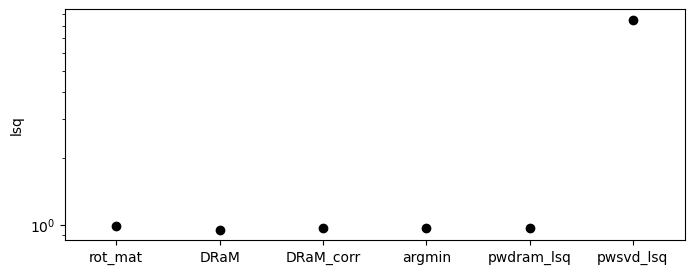

In [146]:
plt.figure(figsize=(8,3))
plt.plot([1,2,3,4,5,6],compare_errors ,'ko');
ticks = [1,2,3,4,5,6]
labels = ["rot_mat", "DRaM","DRaM_corr", "argmin", "pwdram_lsq", "pwsvd_lsq"]
plt.xticks(ticks, labels)
plt.xlim((0.5,6.5))
plt.ylabel('lsq')
plt.yscale('log')

In [99]:
#Just to check the no noise case for arg_min:
U = UV_no_error
quat_argmin_no_error = utils.argmin_f(xyz, U)
quat_argmin_no_error

array([0.99500405, 0.05764049, 0.05763953, 0.05763905])

In [100]:
rotation_argmin_no_error = utils.quat_to_rot(quat_argmin_no_error)

In [101]:
utils.least_squares_4_3D(rotation_argmin_no_error,xyz,UV_no_error)

np.float64(6.658912230097997e-10)

Back to the errorful case - let's plot the xyz points we get if we use the estimated rotations.

In [34]:
#Let's look at the result.
small_rot_error_xyz = rotation_small.dot(np.asarray(xyz_error).T).T
DRaM_xyz = DRaM.dot(xyz.T).T
DRaM_corr_xyz = R_BI.dot(xyz.T).T
argmin_xyz = rotation_argmin.dot(xyz.T).T

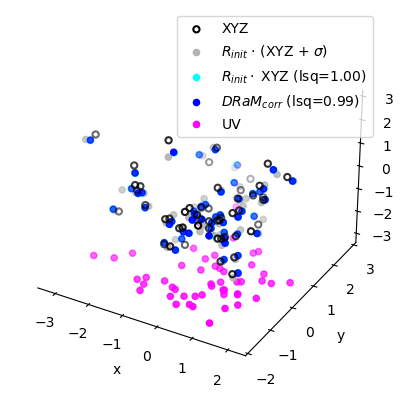

In [49]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2], facecolors='none', edgecolors='k',linewidths=1.5,label='XYZ');
ax.scatter3D(small_rot_error_xyz[:,0],small_rot_error_xyz[:,1],small_rot_error_xyz[:,2],color='0.7',label='$R_{init}$ $\cdot$ (XYZ + $\sigma$)');
ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='$R_{init} \cdot$ XYZ (lsq=%.2f)'%rot_mat_lsq);
ax.scatter3D(DRaM_corr_xyz[:,0],DRaM_corr_xyz[:,1],DRaM_corr_xyz[:,2],color='blue',label='$DRaM_{corr}$ (lsq=%.2f)'%DRaM_corr_lsq);
#ax.scatter3D(argmin_xyz[:,0],argmin_xyz[:,1],argmin_xyz[:,2],color='red',label=r'$R_{argmin}$ (lsq=%.2f)'%argmin_lsq);

ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='UV');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

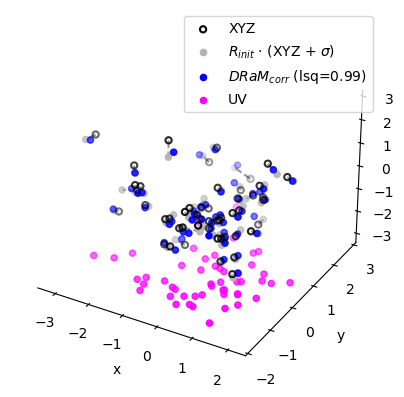

In [50]:
fig = plt.figure();
ax = plt.axes(projection='3d');
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2], facecolors='none', edgecolors='k',linewidths=1.5,label='XYZ');
ax.scatter3D(small_rot_error_xyz[:,0],small_rot_error_xyz[:,1],small_rot_error_xyz[:,2],color='0.7',label='$R_{init}$ $\cdot$ (XYZ + $\sigma$)');
#ax.scatter3D(small_rot_xyz[:,0],small_rot_xyz[:,1],small_rot_xyz[:,2],color='cyan',label='$R_{init} \cdot$ XYZ (lsq=%.2f)'%rot_mat_lsq);
ax.scatter3D(DRaM_corr_xyz[:,0],DRaM_corr_xyz[:,1],DRaM_corr_xyz[:,2],color='blue',label='$DRaM_{corr}$ (lsq=%.2f)'%DRaM_corr_lsq);
#ax.scatter3D(argmin_xyz[:,0],argmin_xyz[:,1],argmin_xyz[:,2],color='red',label=r'$R_{argmin}$ (lsq=%.2f)'%argmin_lsq);

for i in range(len(xyz[:,0])):
    ax.plot([xyz[i,0],small_rot_error_xyz[i,0]],[xyz[i,1],small_rot_error_xyz[i,1]],[xyz[i,2],small_rot_error_xyz[i,2]],color='black',linestyle='--',alpha=0.4);

ax.scatter3D(small_proj_xyz[:,0],small_proj_xyz[:,1],np.zeros(len(small_proj_xyz.T[0]))-3,color='magenta',label='UV');
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()
#still to do: draw chord

## 4. Testing DRaM_corrected with many replicates and various parameters.

In [365]:
import torch
sigma = 0.1
npts = 50
R_set, xyz_set, U_set = simulators.generate_data_3D(100,50,sigma,concentration=torch.tensor([30.0,0,0,0], dtype=float)) #100 replicates, npts=50, sigma=0.1

k_shuffle = npts
shuffle_idx = torch.arange(npts)
shuffle_idx[:k_shuffle] = torch.randperm(k_shuffle)
shuffle_idx

tensor([36, 31, 37, 39, 13,  8, 12, 35, 15,  1, 21,  0, 27, 16, 33, 23, 34, 32,
        14, 18,  6,  4, 43, 19,  7, 41, 28, 17, 24, 47, 10,  9, 29,  2, 22, 25,
         5, 40, 42,  3, 44, 20, 45, 38, 48, 26, 49, 11, 46, 30])

In [366]:
Rt_estimated = [solutions.make_R_tilde(xyz[shuffle_idx], U) for xyz, U in zip(xyz_set, U_set)]
lsq = [utils.least_squares_4_3D(Rt_estimated[idx],xyz[shuffle_idx], U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]
lsq_rot = [utils.least_squares_4_3D(R,xyz[shuffle_idx], U) for (R, xyz, U) in zip(R_set, xyz_set, U_set )]
Mq_estimated = [solutions.make_M_opt_rot(xyz[shuffle_idx],U) for xyz, U in zip(xyz_set, U_set)]
lsq_M = [utils.least_squares_4_3D(Mq_estimated[idx],xyz[shuffle_idx],U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]


In [367]:
#sorting indices to make it more interprettable
lsq_M_sorted_indices = np.argsort(lsq_M)

In [368]:
lsq_M_sortedbyM = [lsq_M[i] for i in lsq_M_sorted_indices]
lsq_sortedbyM  = [lsq[i] for i in lsq_M_sorted_indices]
lsq_rot_sortedbyM  = [lsq_rot[i] for i in lsq_M_sorted_indices]



In [369]:
q_argmin = [utils.argmin_f(xyz[shuffle_idx], U) for xyz, U in zip(xyz_set, U_set)]
R_argmin = [utils.quat_to_rot(q) for q in q_argmin]
lsq_argmin = [utils.least_squares_4_3D(R_argmin[idx],xyz[shuffle_idx],U) for idx, (xyz, U) in enumerate(zip(xyz_set, U_set ))]


In [370]:
lsq_argmin_sortedbyM  = [lsq_argmin[i] for i in lsq_M_sorted_indices]

In [406]:
# TODO: put in solutions
lsq_pwdram = []
rotations_pwdram = []
for idx, (xyz, U) in enumerate(zip(xyz_set, U_set )):

    transport_plan_pwdram, rotation_pwdram, logs = procrustes_wasserstein_2d_3d_dram(xyz, torch.from_numpy(U[shuffle_idx]), verbose_log=True, cost_d=2, tol=1e-6, max_iter=50)
    rotations_pwdram.append(rotation_pwdram)
    pwdram_lsq = utils.least_squares_4_3D(rotation_pwdram, torch.from_numpy(transport_plan_pwdram) @ xyz, U[shuffle_idx])
    point_norm = torch.norm(torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram.T[:,:2]  - U[shuffle_idx])
    lsq_pwdram.append(point_norm)

lsq_pwdram_sortedbyM  = [lsq_pwdram[i] for i in lsq_M_sorted_indices]

/tmp/ipykernel_2434162/867563556.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  point_norm = torch.norm(torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram.T[:,:2]  - U[shuffle_idx])


In [407]:
point_norm

tensor(13.2881, dtype=torch.float64)

In [408]:
lsq_pwdram_sortedbyM

[tensor(11.1450, dtype=torch.float64),
 tensor(12.8109, dtype=torch.float64),
 tensor(11.0323, dtype=torch.float64),
 tensor(12.1333, dtype=torch.float64),
 tensor(10.5658, dtype=torch.float64),
 tensor(12.0496, dtype=torch.float64),
 tensor(10.4203, dtype=torch.float64),
 tensor(11.0732, dtype=torch.float64),
 tensor(11.3763, dtype=torch.float64),
 tensor(11.7072, dtype=torch.float64),
 tensor(11.0597, dtype=torch.float64),
 tensor(13.4076, dtype=torch.float64),
 tensor(11.7879, dtype=torch.float64),
 tensor(12.5907, dtype=torch.float64),
 tensor(11.9237, dtype=torch.float64),
 tensor(11.8585, dtype=torch.float64),
 tensor(12.7253, dtype=torch.float64),
 tensor(11.6883, dtype=torch.float64),
 tensor(12.8046, dtype=torch.float64),
 tensor(11.9785, dtype=torch.float64),
 tensor(9.9514, dtype=torch.float64),
 tensor(12.2044, dtype=torch.float64),
 tensor(11.9447, dtype=torch.float64),
 tensor(11.5969, dtype=torch.float64),
 tensor(11.7270, dtype=torch.float64),
 tensor(11.2949, dtype=tor

In [402]:
assert np.allclose(transport_plan, transport_plan_pwdram)
assert np.allclose(rotation, rotation_pwdram)
assert np.allclose(xyz_permuted_R[:,:2], torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram.T[:,:2])

/tmp/ipykernel_2434162/2729272141.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  assert np.allclose(xyz_permuted_R[:,:2], torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram.T[:,:2])


AssertionError: 

In [ ]:
torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram.T[:,:2]

/tmp/ipykernel_2434162/319990105.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.from_numpy(transport_plan_pwdram) @ xyz @ rotation_pwdram[:,:2]


tensor([[-0.0135, -0.9007],
        [-0.4478, -2.7210],
        [-0.2633, -2.1259],
        [-1.6402,  0.7931],
        [ 0.5578, -1.0769],
        [-1.8650,  0.4582],
        [ 0.1257, -0.8128],
        [-0.4449, -1.8053],
        [-0.1960, -0.3822],
        [-0.5090,  0.4395],
        [-0.7944,  0.5353],
        [-0.5829,  0.6641],
        [-1.2804,  0.3671],
        [-1.5740,  0.7828],
        [ 1.5421, -0.6540],
        [-0.5877,  0.1765],
        [ 0.6819, -0.2717],
        [-1.6073, -1.9737],
        [-2.2567,  0.3840],
        [-0.0072, -0.3760],
        [ 0.0652, -0.1888],
        [-0.7292,  0.1987],
        [-0.1149, -0.3050],
        [ 1.9610, -1.1739],
        [-0.5708,  0.3392],
        [-0.8506, -0.0356],
        [-0.3949,  1.5952],
        [ 1.9106,  1.7525],
        [ 1.5607, -0.4141],
        [ 0.6106, -0.0694],
        [ 0.9540, -0.3616],
        [-0.0258,  0.5207],
        [ 1.7404,  0.5321],
        [-0.5022, -2.0805],
        [-0.5883,  0.1211],
        [ 1.3267,  0

In [403]:
xyz_permuted_R[:,:2]

tensor([[-1.4041, -0.6589],
        [ 0.0043,  0.5410],
        [ 1.5034, -1.2705],
        [ 0.6524,  0.0376],
        [-1.1845,  0.8998],
        [-0.5206, -0.5355],
        [-1.1406,  0.3820],
        [ 1.4204,  0.2330],
        [-0.5056,  0.1911],
        [-0.7360, -2.9065],
        [-0.6991,  0.1858],
        [ 0.0207, -0.9011],
        [ 1.7257,  1.7777],
        [ 0.6373, -0.2681],
        [-0.4278, -2.1023],
        [ 2.0325, -1.0841],
        [-0.6015,  0.0940],
        [ 1.4288,  0.4765],
        [ 1.7035, -0.7115],
        [-2.2058,  0.3221],
        [ 0.0066, -0.8721],
        [ 0.3969, -1.1411],
        [ 1.2606,  1.0660],
        [-0.1190, -0.3163],
        [-0.5749, -1.9081],
        [ 0.3614, -0.7829],
        [ 1.5518, -0.3624],
        [-1.5432, -2.0422],
        [-0.5218,  0.3430],
        [ 0.5864, -0.6918],
        [-0.6043,  0.5938],
        [-0.7258,  0.3333],
        [ 0.9172,  0.0854],
        [-0.3104, -2.1910],
        [ 0.0593, -0.3538],
        [-0.9931, -0

In [409]:
log = logs[-1]
transport_plan = log["transport_plan"]
rotation = log["R"]
xyz_permuted_R = log["xyz_permuted_R"] 

torch.norm(torch.from_numpy(U[shuffle_idx]) - xyz_permuted_R[:,:2])

tensor(12.5752, dtype=torch.float64)

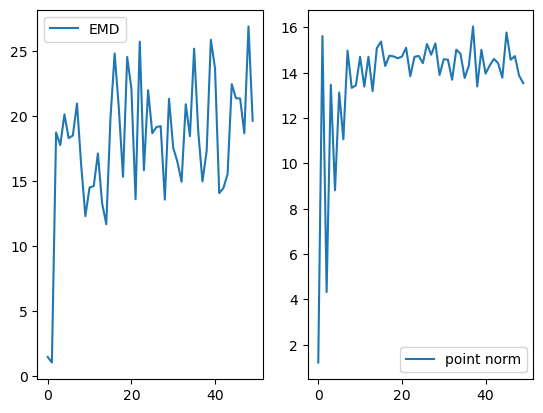

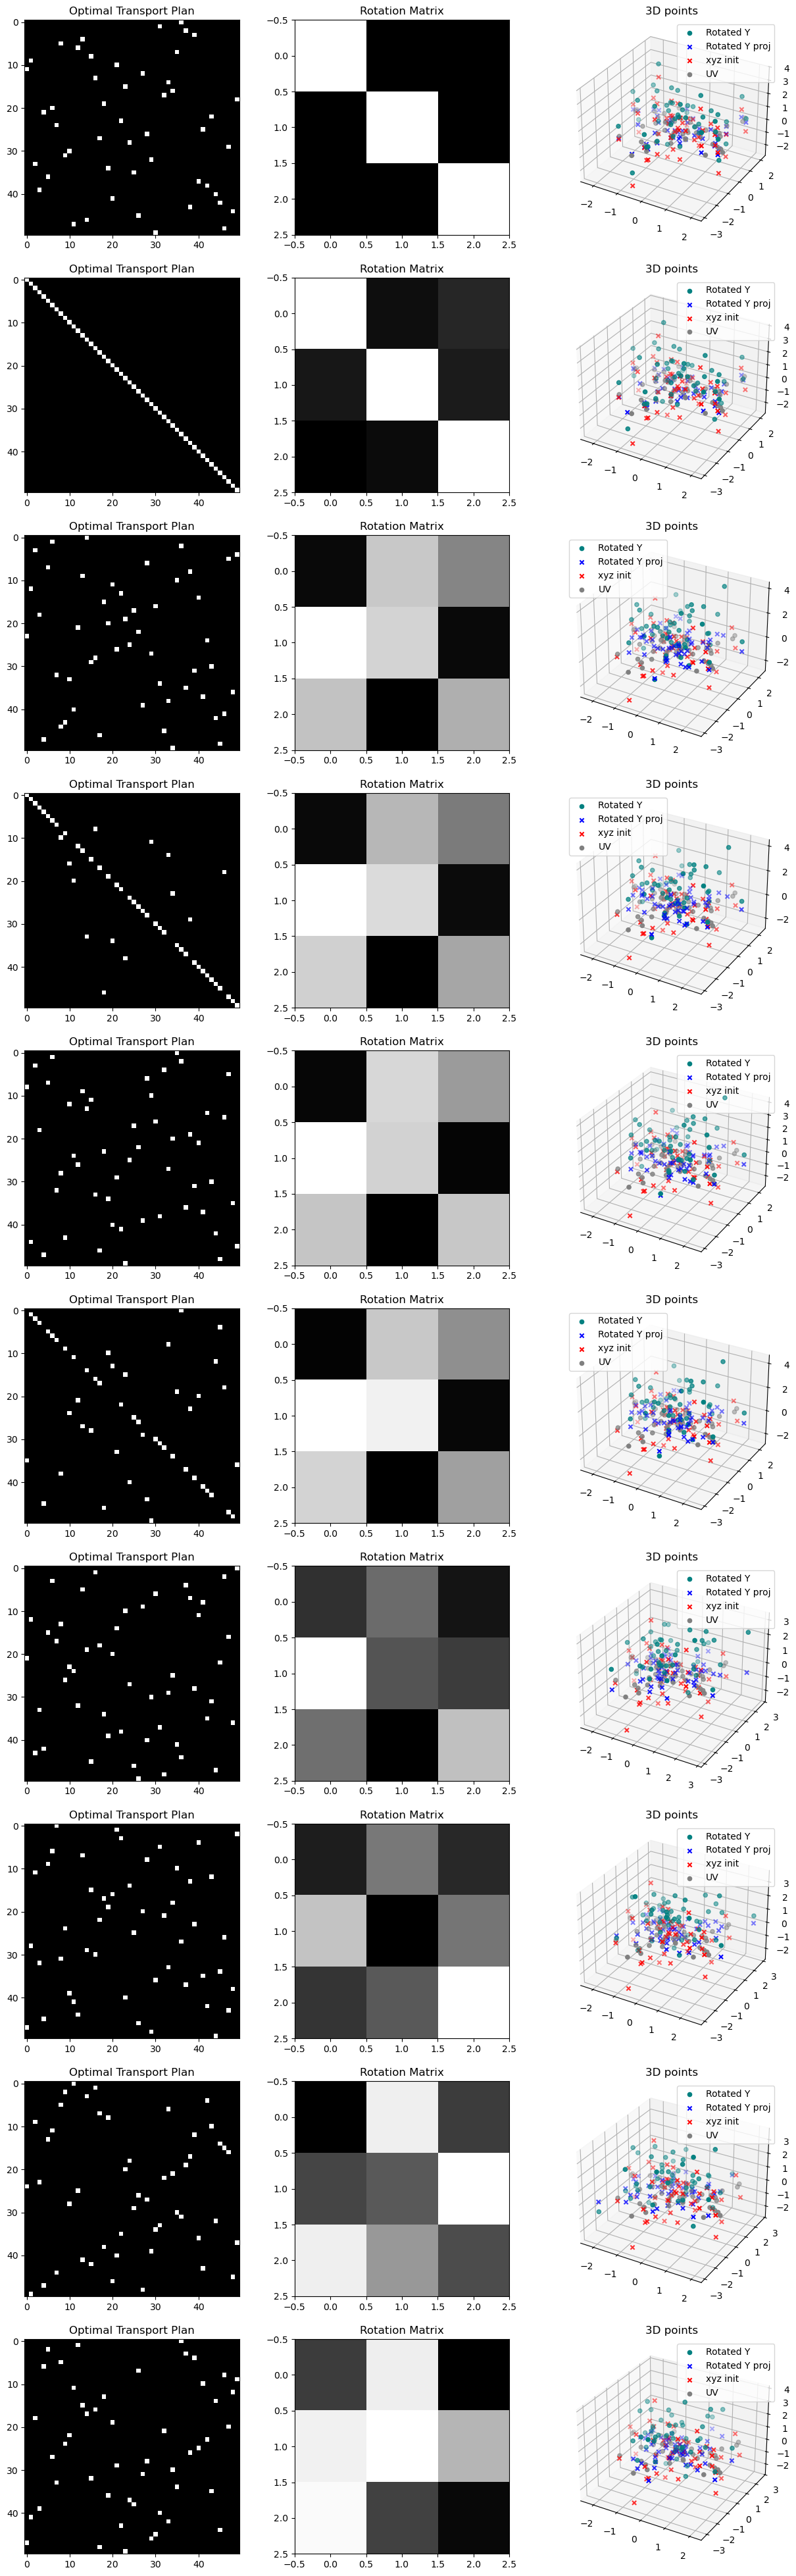

In [410]:
n_pl = min(10, len(logs))
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YpRs = [log['xyz_permuted_R'] for log in logs[:n_pl]]

fig, axes = plt.subplots(1,2)
axes[0].plot([log['cost'] for log in logs], label='EMD')
axes[0].legend()
axes[1].plot([log['point_norm'] for log in logs], label='point norm')
axes[1].legend()
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    # Rotated Y with X in 3D
    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=YpRs[idx][:, 2]+1, label='Rotated Y', marker='o', color='teal')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue')
    ax2.scatter(xs=xyz[:, 0], ys=xyz[:, 1], zs=xyz[:, 2], label='xyz init', marker='x', color='red')
    ax2.scatter(xs=U[:, 0], ys=U[:, 1], zs=0, label='UV', marker='o', color='gray')
    ax2.set_title('3D points')
    ax2.legend()






In [387]:
log['point_norm']

NameError: name 'log' is not defined

In [363]:
diff = [lsq_M[i]-lsq_argmin[i] for i in lsq_M_sorted_indices]
diff_20 = [20*(lsq_M[i]-lsq_argmin[i])+0.55 for i in lsq_M_sorted_indices]

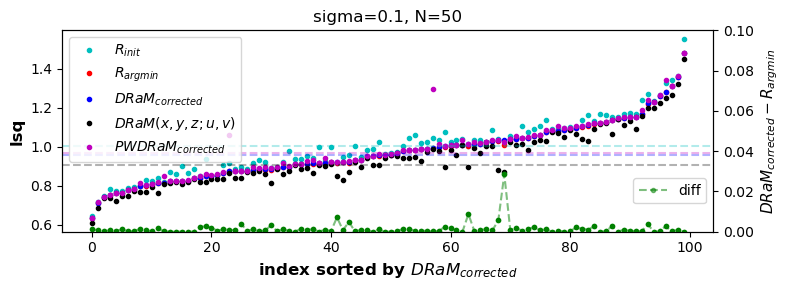

In [364]:
fig,ax = plt.subplots(figsize=[8,3])
plt.plot(lsq_rot_sortedbyM,'c.',label=r'$R_{init}$');
plt.plot(lsq_argmin_sortedbyM,'r.',label=r'$R_{argmin}$');
plt.plot(lsq_M_sortedbyM,'b.',label=r'$DRaM_{corrected}$');
plt.plot(lsq_sortedbyM,'k.',label=r'$DRaM(x,y,z;u,v)$');
plt.plot(lsq_pwdram_sortedbyM,'m.',label=r'$PW DRaM_{corrected}$');
plt.axhline(y=np.median(lsq_M),linestyle='--',color='b',alpha=0.3)
plt.axhline(y=np.median(lsq_rot),linestyle='--',color='c',alpha=0.3)
plt.axhline(y=np.median(lsq),linestyle='--',color='k',alpha=0.3)
plt.axhline(y=np.median(lsq_pwdram),linestyle='--',color='m',alpha=0.3)
plt.legend()
plt.ylabel('lsq',fontsize=12,fontweight='bold')
plt.xlabel(r'index sorted by $DRaM_{corrected}$',fontsize=12,fontweight='bold')
# plt.ylim((0.65,1.5))

ax2=ax.twinx()
ax2.plot(diff,'g.')
ax2.plot(diff,'g.',linestyle='--',alpha=0.5,label='diff')
plt.ylim((0,0.1))
plt.legend(bbox_to_anchor=(1, 0.3))
plt.ylabel(r'$DRaM_{corrected} - R_{argmin}$',fontsize=11,fontweight='bold')

plt.title(f'sigma={sigma}, N=50');
plt.tight_layout();

plt.savefig('DRaM_orthographic.png',dpi=300)
#plt.savefig('DRaM_orthographic.eps',dpi=300)